In [1]:
from src.model import ResNetCustom
from src.albumentations import train_augmentations, test_augmentations
from src.utils import visualize_augmentations
from torchvision.datasets import EMNIST, VisionDataset
from torchvision import transforms
import pytorch_lightning as pl
from torch.utils.data import random_split
import torch
import matplotlib.pyplot as plt
from typing import Any, Optional
import albumentations as A
import numpy as np
import torch.nn.functional as F
import torchmetrics.functional as metrics_F
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

In [3]:
class AlbumentationsMixin:
    def __init__(self, *args, albumentations: Optional[A.Compose] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.albumentations = albumentations

    def __getitem__(self, index: int) -> Any:
        image, label = super().__getitem__(index)
        if self.albumentations is not None:
            image = self.albumentations(image=np.array(image))["image"]
        return image, label


class EMNIST(AlbumentationsMixin, EMNIST):
    pass

In [4]:
BATCH_SIZE = 4096
emnist_train = EMNIST(
    "data/train/",
    train=True,
    download=True,
    albumentations=train_augmentations,
    split="balanced",
)
data_train, data_val = random_split(emnist_train, [0.8, 0.2])
data_test = EMNIST(
    "data/test/",
    train=False,
    download=True,
    albumentations=test_augmentations,
    split="balanced",
)
train_dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, num_workers=12)
val_dataloader = DataLoader(data_val, batch_size=BATCH_SIZE, num_workers=12)
test_dataloader = DataLoader(data_test, batch_size=BATCH_SIZE, num_workers=12)

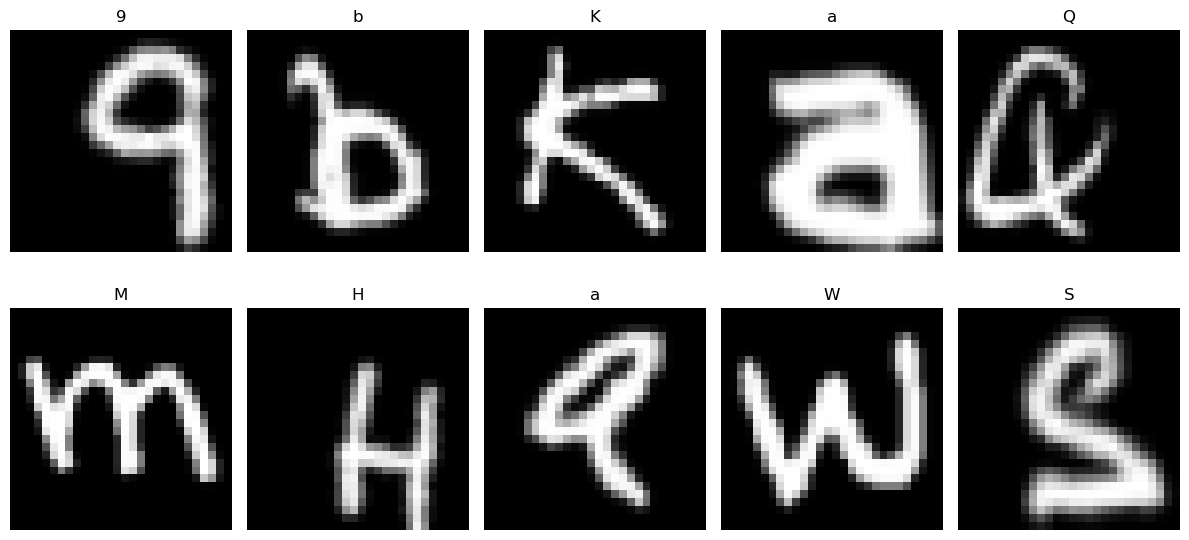

In [8]:
visualize_augmentations(emnist_train)

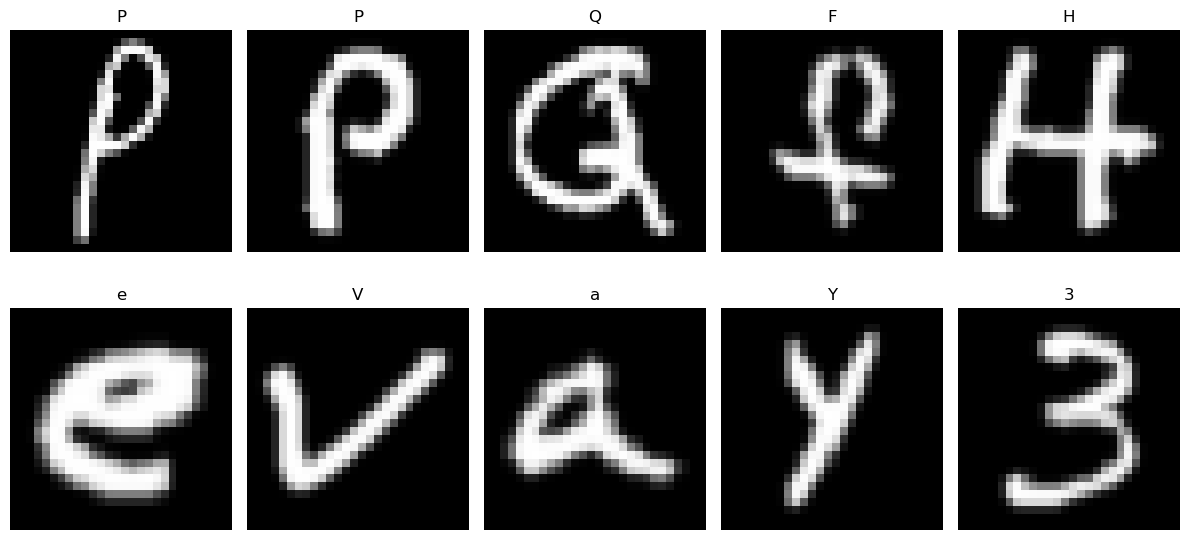

In [9]:
visualize_augmentations(data_test)

In [6]:
class CustomEmnistClassificator(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.classificator = ResNetCustom(len(emnist_train.classes))

    def forward(self, x: torch.Tensor):
        logits = self.classificator(x)
        classes = torch.argmax(logits)
        return classes

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.classificator(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss)

        classes = torch.argmax(logits, axis=1)
        acc = metrics_F.accuracy(classes, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.classificator(x)
        loss = F.cross_entropy(logits, y)
        self.log("val_loss", loss)

        classes = torch.argmax(logits, axis=1)
        acc = metrics_F.accuracy(classes, y)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.classificator(x)
        loss = F.cross_entropy(logits, y)
        self.log("test_loss", loss)

        classes = torch.argmax(logits, axis=1)
        acc = metrics_F.accuracy(classes, y)
        self.log("test_acc", acc)

In [10]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [8]:
model = CustomEmnistClassificator()
trainer = pl.Trainer(
    accelerator="gpu",
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss", mode="min", patience=20
        )
    ],
)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/korzhuk/miniconda3/envs/pl/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | classificator | ResNetCustom | 683 K 
-----------------------------------------------
683 K     Trainable params
0         Non-trainable params
683 K     Total params
2.735     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/korzhuk/miniconda3/envs/pl/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
trainer.validate(model, train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.877626359462738
        val_loss            3.0107924938201904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 3.0107924938201904, 'val_acc': 0.877626359462738}]

In [10]:
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8655850887298584
        test_loss            3.022264003753662
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.022264003753662, 'test_acc': 0.8655850887298584}]